<div align="center"> <h1>EECS 738 Machine Learning</h1>
    <h2>Project 1</h2>
    <h3>Submitted by Nitish Gupta<h3>
        </div>
        
      

In [1151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing

<center> <h3>Implementation of Gaussian Mixture Model and EM </h3></center>    

<b>[1]  `gaussian_density()`</b>  
This function implements the multivariate guassian density function using the following equation

\begin{equation}
\large
\mathcal N(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{D/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}

<b>[2]  `initialize()`</b>   
This function initializes the cluster parameters for `no_clusters` different clusters  

<b>[3]  `expectation()`</b>   
This function implements the expectation equation (\gamma_k) obtained using Bayes Theorem
\begin{equation}
\large
\gamma_k{(x_{n})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{l}\pi_l\mathcal N(\mathbf x_n| \mathbf\mu_l, \mathbf\Sigma_l)}
\end{equation}

<b>[4]  `exp_maximization()`</b>  
This function maximizes the expectation by iteratively updating the GMM parameters (mean, variance, weights)

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma_k({x_{n}})
\end{equation}

\begin{equation}
\large
\pi_k^{new}=\frac {N_k} N
\end{equation}


\begin{equation}
\large
\mu_k^{new}=\frac 1 {N_k} \sum_{n=1}^N\gamma_k({x_{n}})\mathbf x_n
\end{equation}


\begin{equation}
\large
\Sigma_k^{new}=\frac 1 {N_k} \sum_{n=1}^N\gamma_k({x_{n}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

<b>[5]  `get_likelihood()`</b>  
This function calculates log likelihood using the following equation
\begin{equation}
\large
\ln p(\mathbf X | \pi,\mu,\Sigma)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

<b>[5]  `predict()`</b>  
Predict function returns the cluster number for the given input based on maximum expectation

In [1152]:
class gmm_data_model:
    
    clusters = []
    no_clusters = 0
    
    def gaussian_density(self, X, mean, covariance):
        try:
            D = X.shape[1]
            diff = (X - mean).T
            N_x_mu_cov = 1 / ((2 * np.pi)**(D/2) * np.linalg.det(covariance)**0.5) * np.exp(
                -0.5 * np.dot(np.dot(diff.T, np.linalg.pinv(covariance)), diff)) 
            return np.diagonal(N_x_mu_cov).reshape(-1, 1)
        except:
            pass

    
    def initialize(self, X, nclusters):
        # initialize with random mean
        mean_k = np.random.rand(X.shape[1])
        self.no_clusters = nclusters
        
        self.clusters = []
        covariance_start = np.identity(X.shape[1], dtype=np.float64)
        
        for i in range(nclusters):
            self.clusters.append({"mean_k": mean_k[i], "sigma_k":covariance_start, "pi_k":1/nclusters})
            
    
    def expectation(self, X):
        N = X.shape[0]
        den = np.zeros((N, 1), np.float64)
        
        for c in self.clusters:
            num = (c["pi_k"] * self.gaussian_density(X, c["mean_k"], c["sigma_k"])).astype(np.float64)
            
            for i in range(N):
                den[i] += num[i]
            c["num"] = num
            c["den"] = den            
            
        for c in self.clusters:
            c["gamma_k"] = c["num"] / c["den"]
        
        
    def exp_maximization(self, X):
        N = X.shape[0]
        D = X.shape[1]
        
        for c in self.clusters:
            Nk = np.sum(c["gamma_k"], axis=0)
            c["pi_k"] = Nk/N
            c["mean_k"] = np.sum(c["gamma_k"] * X, axis=0) / Nk
            new_sigma = np.zeros((D,D), dtype=np.float64)

            for i in range(N):
                sub_term = (X[i] - c["mean_k"]).reshape(-1, 1)
                new_sigma += (c["gamma_k"][i] * np.dot(sub_term, sub_term.T))  
            c["sigma_k"] = new_sigma / Nk

            
    def get_likelihood(self):
        likelihoods = []
        for c in self.clusters:
            likelihoods.append(np.log(c["den"]))
        return (np.sum(likelihoods), np.array(likelihoods))
    
    
    def train_model(self, data, no_clusters, no_epoch):
        self.initialize(data, no_clusters)
        log_likelihood_storage = []
        
        for i in range(no_epoch):
            self.expectation(data)
            self.exp_maximization(data)
            log_likelihood_sum, all_likelihoods = self.get_likelihood()
            log_likelihood_storage.append(log_likelihood_sum)
            print(i, " Epoch ==> Likelihood:", log_likelihood_sum)
        
        preds = np.zeros((data.shape[0], self.no_clusters))
        
        for i, c in enumerate(self.clusters):
            preds[:, i] = c['gamma_k'].reshape(-1)
            
        return log_likelihood_storage, preds
        

    def predict(self, data):
        preds = np.zeros((data.shape[0], self.no_clusters))
        
        for i, c in enumerate(self.clusters):
            preds[:, i] = c['gamma_k'].reshape(-1)
            
        return np.argmax(preds, axis=1)

### Normalize the dataset before optimizing the parameters
Here we use Sklearn library's `fit_transform` to normalize entire dataset between (0,1)

In [1153]:
def normalize(data):
    x = data.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X = pd.DataFrame(x_scaled, columns=data.columns.values)
    return X

# plot_histograms(data_scaled, title='Data Distribution (After Normalization)')

### Helper Plotting Function
This function takes any data and creates a histogram corresponding to each feature vector

In [1154]:
def plot_histograms(data, title):
    
    fig, axs = plt.subplots(math.ceil(data.shape[1]/4), 4)
    col = 0
    
    plt.subplots_adjust(wspace=0.4, hspace=0.7)
    fig.suptitle(title, fontsize=15)
    
    for i in range(math.ceil(data.shape[1]/4)):
        for j in range(4):
            if col < data.shape[1] and data.dtypes[col] in [np.float64, np.int64]:
                axs[i][j].hist(data[data.columns.values[col]], bins=50)
                axs[i][j].set_title(data.columns.values[col])
            col += 1
        
    plt.show()

## <center> Dataset 0: Iris Data

In [1178]:
data = pd.read_csv("./data/iris/iris.data", header=None, delimiter=",")

# Convert the output feature vector from str to unique integer values
unique_value, index = np.unique(data[4], return_inverse=True) 
data[4] = index

# Shuffle the dataframe
data = data.sample(frac = 1)

# Separate output feature vector from input features
y_actuals = data.values[:,-1]
X = data.drop([4], axis=1)

X.head()

,0,1,2,3
87,6.3,2.3,4.4,1.3
100,6.3,3.3,6.0,2.5
103,6.3,2.9,5.6,1.8
89,5.5,2.5,4.0,1.3
14,5.8,4.0,1.2,0.2


In [1156]:
# Information about the input data
X.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [1157]:
# Correlation matrix to find the relationship between all input features
X.corr()

,0,1,2,3
0,1.000000,-0.109369,0.871754,0.817954
1,-0.109369,1.000000,-0.420516,-0.356544
2,0.871754,-0.420516,1.000000,0.962757
3,0.817954,-0.356544,0.962757,1.000000


In [1158]:
# Normalizing input data

# plot_histograms(X, title='Data Distribution (Before Normalization)')
X = normalize(X).values
# plot_histograms(data, title='Data Distribution (After Normalization)')

### Creating a GMM class instance
- Training the model (clusters) parameters
- Plotting the log likelihood over entire training

0  Epoch ==> Likelihood: -1885.8407320283093
1  Epoch ==> Likelihood: 1047.6632098043344
2  Epoch ==> Likelihood: 1089.1442867412127
3  Epoch ==> Likelihood: 1152.130517887545
4  Epoch ==> Likelihood: 1239.805988918902
5  Epoch ==> Likelihood: 1298.462407702664
6  Epoch ==> Likelihood: 1324.7481708957685
7  Epoch ==> Likelihood: 1358.1391919365965
8  Epoch ==> Likelihood: 1421.3273711233091
9  Epoch ==> Likelihood: 1541.741337401902
10  Epoch ==> Likelihood: 1551.5806836483434
11  Epoch ==> Likelihood: 1558.966980447325
12  Epoch ==> Likelihood: 1568.1438253053816
13  Epoch ==> Likelihood: 1581.2606725977396
14  Epoch ==> Likelihood: 1589.1714262698156
15  Epoch ==> Likelihood: 1591.2380187462759
16  Epoch ==> Likelihood: 1591.970185583306
17  Epoch ==> Likelihood: 1592.2855863252935
18  Epoch ==> Likelihood: 1592.4419236561307
19  Epoch ==> Likelihood: 1592.522955441052
20  Epoch ==> Likelihood: 1592.5656255530555
21  Epoch ==> Likelihood: 1592.5882765069023
22  Epoch ==> Likelihood: 

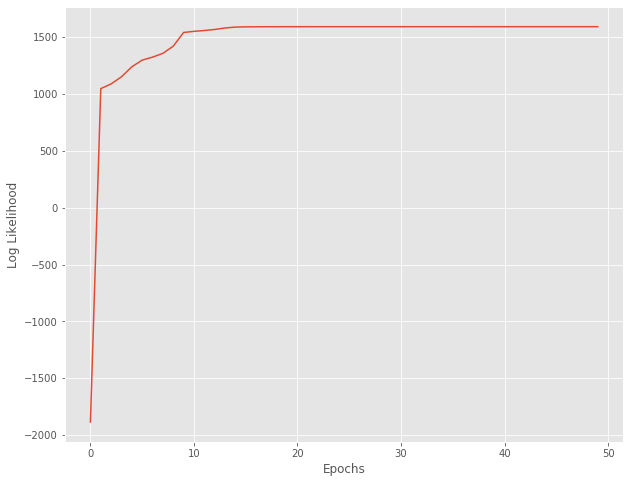

In [1159]:
a = gmm_data_model()

no_of_clusters = 3
epochs = 50
likelihoods, scores = a.train_model(X, no_of_clusters, epochs)
plt.plot(likelihoods)
plt.xlabel("Epochs")
plt.ylabel("Log Likelihood")
plt.show()

### Plotting and Comparing the predictions
- plotting the predicted data clusters for 0th and 2nd feature vector 
- plotting the actual data clusters for 0th and 2nd feature vector 

[0 0 1 1 2 2 1 1 1 2 1 1 0 0 0 2 1 1 2 2 1 1 0 0 2 0 1 2 2 2 2 2 0 2 1 2 1
 1 0 1 1 1 1 2 0 1 1 2 0 1 1 1 1 1 1 1 2 0 1 1 1 2 0 0 0 2 2 0 0 2 2 2 2 1
 0 1 0 0 0 2 0 1 1 0 2 1 0 0 2 2 1 1 1 0 1 1 1 1 1 1 1 2 1 0 0 0 1 2 1 1 0
 2 0 1 1 0 0 0 2 1 0 0 1 2 0 2 1 2 0 0 1 1 0 1 2 0 0 0 0 1 0 2 0 2 2 2 0 0
 2 0]
[0 0 1 1 1 2 1 1 1 2 2 1 0 0 0 2 1 2 2 2 1 1 0 0 1 0 2 2 2 2 2 2 0 2 1 2 1
 1 0 1 1 1 1 2 0 1 1 2 0 1 1 1 2 1 1 2 2 0 2 1 2 2 0 0 0 1 2 0 0 2 2 2 1 2
 0 1 0 0 0 2 0 2 2 0 2 1 0 0 2 1 1 1 2 0 1 1 2 1 1 2 1 2 2 0 0 0 2 2 1 2 0
 2 0 1 1 0 0 0 2 1 0 0 1 2 0 2 1 2 0 0 1 1 0 1 1 0 0 0 0 1 0 2 0 2 2 1 0 0
 2 0]


Text(0.5, 1.0, 'Actual Clusters')

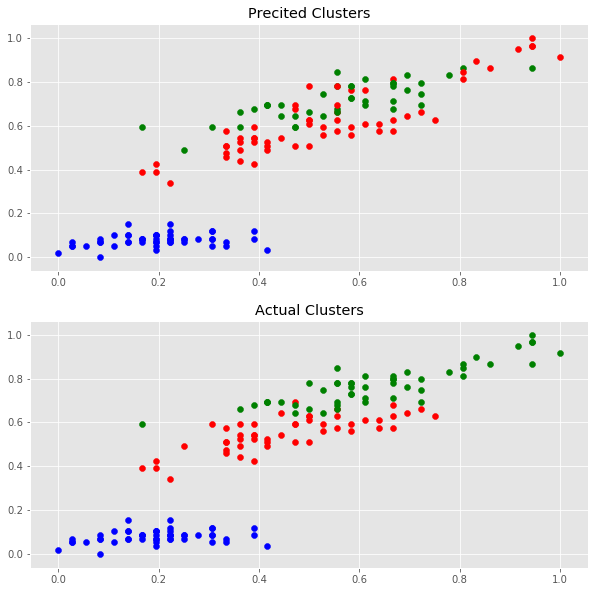

In [1160]:
print(np.argmax(scores, axis=1))
print(np.int32(y_actuals))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
colorpick = ['blue', 'red', 'green']

for i in range(X.shape[0]):
    ax[0].scatter(X[i, 0], X[i, 2], c=colorpick[np.argmax(scores[i])], marker='o')
    ax[1].scatter(X[i, 0], X[i, 2], c=colorpick[np.int32(y_actuals)[i]], marker='o')

ax[0].set_title("Precited Clusters")
ax[1].set_title("Actual Clusters")

## <center>Dataset 1 : Wisconsin Diagnostic Breast Cancer

In [1161]:
data = pd.read_csv("./data/cancer/wdbc.data", header=None)
X = data.drop([0], axis=1)
X = X.drop([1], axis=1)
X.head()

# Separate output feature vector from input features
y_actuals = data[1].map({'M':0,'B':1}).values
data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [1162]:
# Information about the input data
data.describe()

,0,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


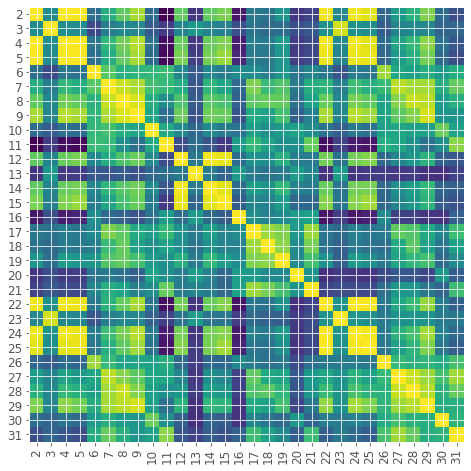

In [1163]:
# Correlation matrix to find the relationship between all input features
plt.imshow(X.corr())
plt.xticks(np.arange(len(X.corr().index.values)), X.corr().index.values, fontsize=12, rotation=90)
plt.yticks(np.arange(len(X.corr().index.values)), X.corr().index.values, fontsize=12)
plt.show()

In [1164]:
# Normalize Data
X = normalize(X).values

### Histograms of all the input features

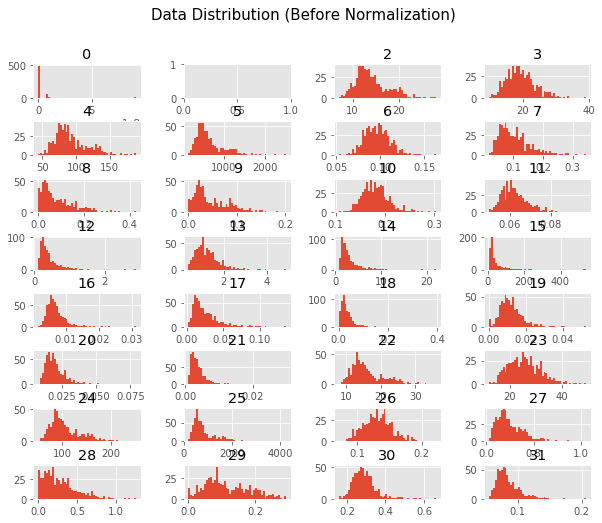

In [1165]:
plot_histograms(data, title='Data Distribution (Before Normalization)')

### Creating a GMM class instance
- Training the model (clusters) parameters
- Plotting the log likelihood over entire training

0  Epoch ==> Likelihood: -37498.10602724172
1  Epoch ==> Likelihood: 61540.90948724892
2  Epoch ==> Likelihood: 66365.28264799132
3  Epoch ==> Likelihood: 67262.94012404338
4  Epoch ==> Likelihood: 67598.072149091
5  Epoch ==> Likelihood: 67799.6989164985
6  Epoch ==> Likelihood: 67938.3861304406


<ipython-input-1152-eef57a231f99>:10: RuntimeWarning: overflow encountered in exp
  N_x_mu_cov = 1 / ((2 * np.pi)**(D/2) * np.linalg.det(covariance)**0.5) * np.exp(
<ipython-input-1152-eef57a231f99>:10: RuntimeWarning: overflow encountered in multiply
  N_x_mu_cov = 1 / ((2 * np.pi)**(D/2) * np.linalg.det(covariance)**0.5) * np.exp(


7  Epoch ==> Likelihood: 68082.7040050952
8  Epoch ==> Likelihood: 68205.88660937549
9  Epoch ==> Likelihood: 68324.20112639011
10  Epoch ==> Likelihood: 68357.15341294536
11  Epoch ==> Likelihood: 68389.42413958193
12  Epoch ==> Likelihood: 68456.9585958631
13  Epoch ==> Likelihood: 68543.37391693579
14  Epoch ==> Likelihood: 68590.97234063692
15  Epoch ==> Likelihood: 68635.99933093728
16  Epoch ==> Likelihood: 68663.16927989387
17  Epoch ==> Likelihood: 68690.59218679846
18  Epoch ==> Likelihood: 68707.06748181536
19  Epoch ==> Likelihood: 68734.44597252083


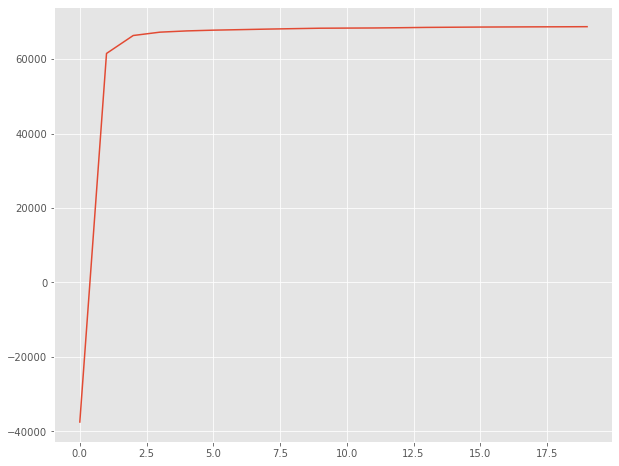

In [1166]:
a = gmm_data_model()
likelihoods, scores = a.train_model(X, 2, 20)
plt.plot(likelihoods)
plt.xlabel("Epochs")
plt.ylabel("Log Likelihood")
plt.show()

### Plotting and Comparing the predictions
- plotting the predicted data clusters for 0th and 2nd feature vector 
- plotting the actual data clusters for 0th and 2nd feature vector 

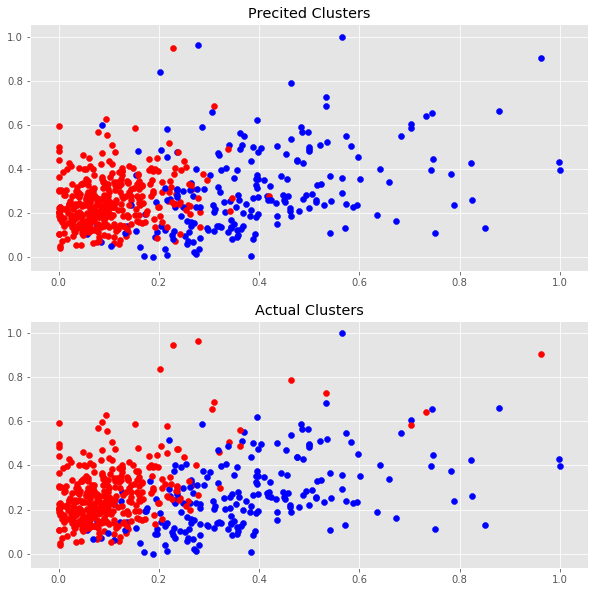

In [1167]:
# print(np.argmax(scores, axis=1))
# print(np.int32(y_actuals))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
colorpick = ['blue', 'red', 'green']

for i in range(X.shape[0]):
    ax[0].scatter(X[i, 6], X[i, 9], c=colorpick[np.argmax(scores[i])], marker='o')
    ax[1].scatter(X[i, 6], X[i, 9], c=colorpick[np.int32(y_actuals)[i]], marker='o')

ax[0].set_title("Precited Clusters")
ax[1].set_title("Actual Clusters")
plt.show()

## Wine Quality Data

In [1173]:
data_red = pd.read_csv("./data/wine/winequality-red.csv", header=0, delimiter=";")
data_white = pd.read_csv("./data/wine/winequality-white.csv", header=0, delimiter=";")

data = pd.concat([data_red, data_white])
y_actuals = np.int32(data.values[:,-1])

for i,y_i in enumerate(y_actuals):
    if y_i <= 6:
        y_actuals[i] = 1
    else:
        y_actuals[i] = 0

X = data.drop(['quality'], axis=1)
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [1174]:
X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


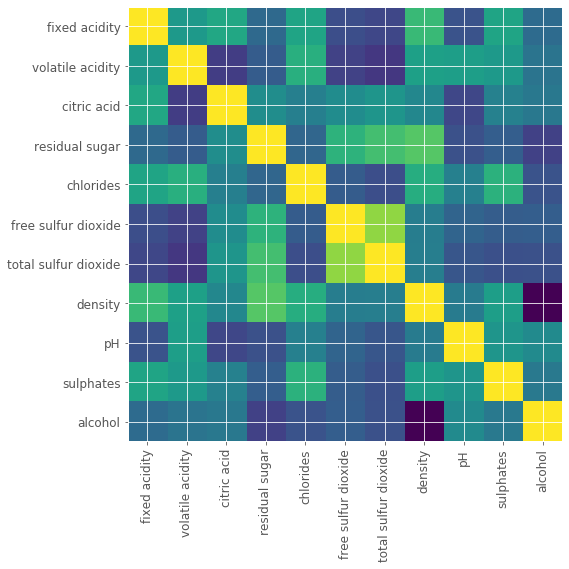

In [1175]:
X.corr()
plt.imshow(X.corr())
plt.xticks(np.arange(len(X.corr().index.values)), X.corr().index.values, fontsize=12, rotation=90)
plt.yticks(np.arange(len(X.corr().index.values)), X.corr().index.values, fontsize=12)
plt.show()

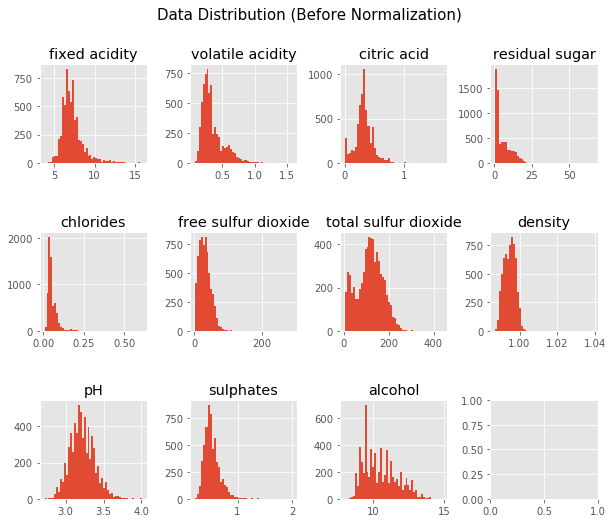

In [1176]:
plot_histograms(X, title='Data Distribution (Before Normalization)')
X = normalize(X).values

0  Epoch ==> Likelihood: -133586.56117520822
1  Epoch ==> Likelihood: 176526.90308773116
2  Epoch ==> Likelihood: 177322.25709232475
3  Epoch ==> Likelihood: 183167.8587552142
4  Epoch ==> Likelihood: 189637.2879027428


<ipython-input-1152-eef57a231f99>:10: RuntimeWarning: overflow encountered in multiply
  N_x_mu_cov = 1 / ((2 * np.pi)**(D/2) * np.linalg.det(covariance)**0.5) * np.exp(


5  Epoch ==> Likelihood: 192132.94547056238
6  Epoch ==> Likelihood: 192622.11488077877
7  Epoch ==> Likelihood: 192891.4601790846
8  Epoch ==> Likelihood: 193201.82502260891
9  Epoch ==> Likelihood: 193750.56002842763
10  Epoch ==> Likelihood: 195160.81420254565
11  Epoch ==> Likelihood: 197992.90110237862
12  Epoch ==> Likelihood: 198924.24392951728
13  Epoch ==> Likelihood: 198983.19034289644
14  Epoch ==> Likelihood: 198996.2330154184
15  Epoch ==> Likelihood: 199000.1806143033
16  Epoch ==> Likelihood: 199001.40617444768
17  Epoch ==> Likelihood: 199001.79923576402
18  Epoch ==> Likelihood: 199001.93870373763
19  Epoch ==> Likelihood: 199001.9931587146


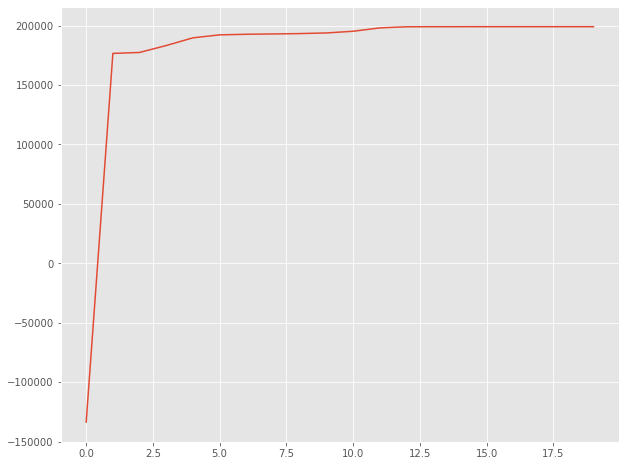

In [1177]:
a = gmm_data_model()
likelihoods, scores = a.train_model(X, 2, 20)
plt.plot(likelihoods)
plt.xlabel("Epochs")
plt.ylabel("Log Likelihood")
plt.show()

[1 1 1 ... 0 0 0]
[1 1 1 ... 1 0 1]


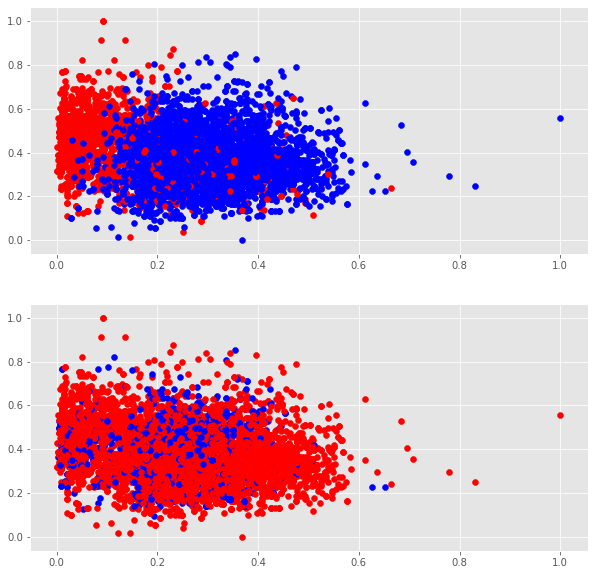

In [1087]:
# print(np.argmax(scores, axis=1))
# print(np.int32(y_actuals))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
colorpick = ['blue', 'red', 'green', 'yellow', 'darkorange', 'limegreen', 'royalblue']

for i in range(X.shape[0]):
    ax[0].scatter(X[i, 6], X[i, 8], c=colorpick[np.argmax(scores[i])], marker='o')
    ax[1].scatter(X[i, 6], X[i, 8], c=colorpick[np.int32(y_actuals)[i]], marker='o')

ax[0].set_title("Precited Clusters")
ax[1].set_title("Actual Clusters")